In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 및 DataLoader 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위로 정규화
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.91MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.00MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import torch
import torch.nn as nn

image_size = 28      # Fashion MNIST 이미지 크기
num_classes = 10     # 10개 클래스
latent_dim = 100     # 잠재 공간 차원

# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

Fake images shape: torch.Size([16, 1, 28, 28])
Validity shape: torch.Size([16, 1])


In [ ]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 30
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [1/30]  D_loss: 0.8108  G_loss: 1.1426
Epoch [2/30]  D_loss: 0.8150  G_loss: 1.1652
Epoch [3/30]  D_loss: 0.7865  G_loss: 2.2752
Epoch [4/30]  D_loss: 0.5697  G_loss: 1.7309
Epoch [5/30]  D_loss: 0.8884  G_loss: 2.9916
Epoch [6/30]  D_loss: 0.6295  G_loss: 1.7822
Epoch [7/30]  D_loss: 0.8390  G_loss: 0.7846
Epoch [8/30]  D_loss: 0.9892  G_loss: 2.4573
Epoch [9/30]  D_loss: 1.2021  G_loss: 2.4757
Epoch [10/30]  D_loss: 0.9890  G_loss: 1.9012


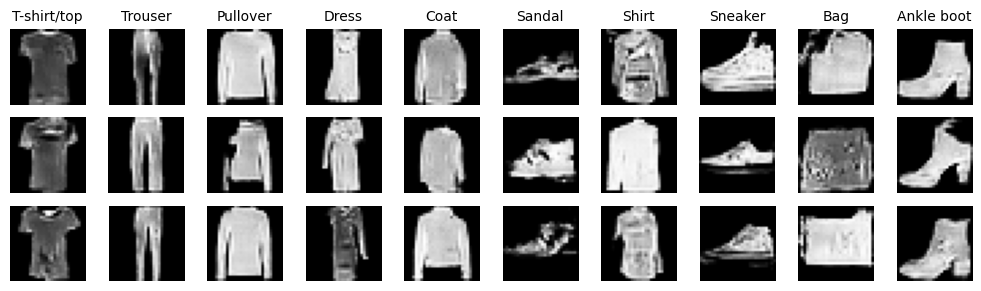

Epoch [11/30]  D_loss: 0.9325  G_loss: 1.0255
Epoch [12/30]  D_loss: 1.0822  G_loss: 2.2189
Epoch [13/30]  D_loss: 0.8969  G_loss: 0.7880
Epoch [14/30]  D_loss: 0.9136  G_loss: 2.0151
Epoch [15/30]  D_loss: 0.9781  G_loss: 2.8613
Epoch [16/30]  D_loss: 0.6496  G_loss: 2.3025
Epoch [17/30]  D_loss: 0.5969  G_loss: 2.3563
Epoch [18/30]  D_loss: 1.0274  G_loss: 3.5628
Epoch [19/30]  D_loss: 0.6871  G_loss: 1.7598
Epoch [20/30]  D_loss: 0.7940  G_loss: 1.2622


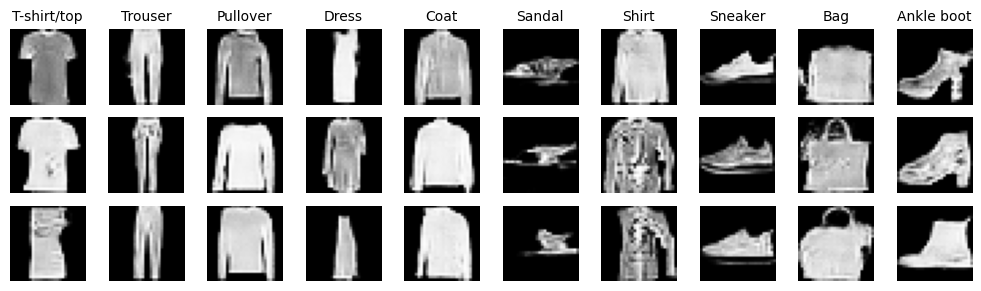

Epoch [21/30]  D_loss: 0.5855  G_loss: 2.3879
Epoch [22/30]  D_loss: 0.6929  G_loss: 1.6223
Epoch [23/30]  D_loss: 0.8389  G_loss: 1.7404
Epoch [24/30]  D_loss: 0.7442  G_loss: 1.9555
Epoch [25/30]  D_loss: 0.6139  G_loss: 2.0437
Epoch [26/30]  D_loss: 0.8827  G_loss: 1.4055
Epoch [27/30]  D_loss: 0.8505  G_loss: 1.4240
Epoch [28/30]  D_loss: 1.0759  G_loss: 2.5555
Epoch [29/30]  D_loss: 0.7521  G_loss: 2.8447
Epoch [30/30]  D_loss: 0.8619  G_loss: 1.4142


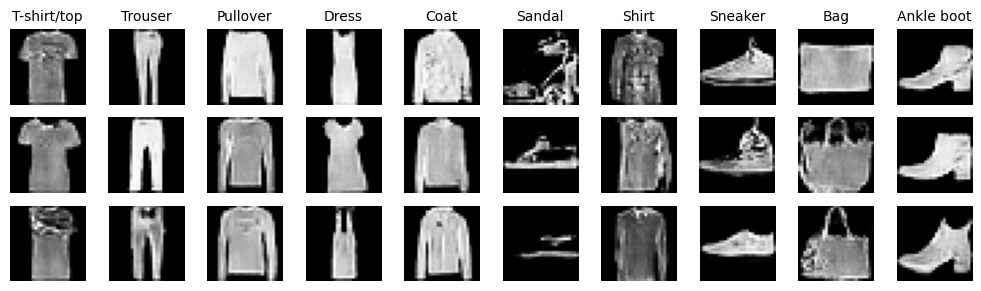

In [ ]:
# 학습 루프
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs, labels), valid)

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels
        gen_imgs = generator(noise, gen_labels)
        fake_loss = criterion(discriminator(gen_imgs.detach(), labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        generator.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples = n_row * n_col
        noise = torch.randn(total_samples, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        gen_imgs = generator(noise, labels_sample).detach().cpu()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                if i == 0:
                    axs[i, j].set_title(idx_to_class[j], fontsize=10)
        plt.tight_layout()
        plt.show()
        generator.train()